In [2]:
from bs4 import BeautifulSoup
import urllib
import urllib.request as ur
import pandas as pd
from datetime import datetime
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from urllib.request import Request, urlopen
import random
import matplotlib.pyplot as plt
import os
import json
import time

In [5]:
def comment_scrape(WEBSITE, Page):
    comments = []
    rates = []
    dates = []

    # type in the website you want to scrape and analyze the trends over time!!!!!
    # example WEBSITE = 'www.betfair.com'
    
    user_agents_list = [
            'Mozilla/5.0 (iPad; CPU OS 13_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_16_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36',
            'python-requests/3.10.0',
            'python-requests/2.14.0',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36',
            'Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1',
            'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36 Edg/87.0.664.75',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18363',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:53.0) Gecko/20100101 Firefox/53.0',
            'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0; Trident/5.0)',
            'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.2; Trident/6.0; MDDCJS)',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.79 Safari/537.36 Edge/14.14393',
            'Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1)'
        ]
    

    for page in range(1, Page):
        time.sleep(random.randint(0, 2))
        if page == 1:
            req = Request(
                    url='https://www.trustpilot.com/review/'+ WEBSITE + '?languages=all&sort=recency',
                    headers={'User-Agent': random.choice(user_agents_list)}
                )
#             url = ur.urlopen('https://www.trustpilot.com/review/'+ WEBSITE)

        else:
            req = Request(
                    url='https://www.trustpilot.com/review/'+ WEBSITE +'?languages=all&page={}&sort=recency'.format(str(page)),
                    headers={'User-Agent': random.choice(user_agents_list)}
                )
            
#             url = ur.urlopen('https://www.trustpilot.com/review/'+ WEBSITE +'?page=' + str(page))
            
        content = urlopen(req).read()
        soup = BeautifulSoup(content, 'lxml')

        table_com_date = soup.findAll('div',attrs={"class":"styles_reviewContent__0Q2Tg"})
        table_rate = soup.findAll('div',attrs={"class":"styles_reviewHeader__iU9Px"})

        # scrape rates
        for x in table_rate:
            rates.append(x['data-service-review-rating'])

        # scrape comments and dates
        for x in table_com_date:

            comments.append(x.find('p').text)
            date = x.find('p', attrs = {"class": "typography_body-m__xgxZ_ typography_appearance-default__AAY17 typography_color-black__5LYEn"}).text[20:]
            date = datetime.strptime(date , "%B %d, %Y")
            dates.append(date)
        
    d = {'Review': comments, 'Rate': rates,'Date': dates }
    df = pd.DataFrame(d)
    df = df.set_index(['Date'])
    
    # print ratio
    print('Rate counts shows below:')
    print(df['Rate'].value_counts())
    print('\nRate counts ratio shows below:')
    print(df.Rate.value_counts(normalize=True))
    
    print('\nReview groupby year shows below:')
    print(df.groupby(df.index.year)['Review'].count())
    
    print('\nScraped ' + str(len(df)) + ' reviews of ' + WEBSITE)
    
    return df

In [7]:
def trends_analyze(filename, Rate, Date):
    
    # read
    df = pd.read_csv (filename, lineterminator='\n')

    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] = [datetime.strptime(df['Date'].iloc[i], "%Y-%m-%d") for i in range(len(df['Review']))]
    df = df.set_index(['Date'])
    df = df.loc[df['Rate'] == Rate].loc[Date]
    
    sentence = " ".join(df['Review'])
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]

    # #counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))

    # #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)
    
    return word_freq, word_pairs, trigrams
    

In [8]:
def plot_chart(word_freq, word_pairs, trigrams):
    # create subplot of the different data frames
    fig, axes = plt.subplots(3,1,figsize=(9,15))
    sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
    sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
    sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))
    
    return 

In [9]:
def review_star_split(df):
    df['Rate'] = df['Rate'].astype(float)
    
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(9, 4))

    df['Rate'].plot(kind='hist', edgecolor='black',ax=axes[0])
    axes[0].set_title("Review Star Distribution")
    
    df = df.groupby([df.index.year, "Rate"]).count()
    df = df.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))
    df.unstack().plot(kind='bar', stacked=True, ax=axes[1])
    
    axes[1].set_title("Review Star Percentage over Time")
    axes[1].legend(title="")
    plt.show()
    return

In [10]:
def review_volume_trend(df):
    df['Rate'] = df['Rate'].astype(float)
    
    fig = plt.figsize=(6, 6)
    df = df.groupby(df.index.year).count().pop('Review')
    df.plot(kind='bar', stacked=True)
    plt.title("Review Volume Trend")
    plt.show()

    return

In [11]:
def review_pie_chart(df):
    
    df['Rate'] = df['Rate'].astype(float)
    
    fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(12, 9))
    
    number_group = df.groupby(df.index.year).ngroups
    
    df = df.groupby([df.index.year, "Rate"]).count()
    df = df.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))

    
    for i, e in enumerate(df.index.levels[0]):
        yy = df.loc[e]["Review"].tolist()

        axes[i//4 , i%4].pie(yy,  autopct='%1.1f%%', shadow=True, startangle=90)
        axes[i//4 , i%4].set_title(e)
        
    plt.show()
    
    return

In [4]:
# Single Company (1)

WEBSITE = 'lendingclub.com'
Page = 229
df = comment_scrape(WEBSITE, Page)
df.to_csv('review.csv')

Rate counts shows below:
5    4067
4     268
1     123
3      69
2      33
Name: Rate, dtype: int64

Rate counts ratio shows below:
5    0.891886
4    0.058772
1    0.026974
3    0.015132
2    0.007237
Name: Rate, dtype: float64

Review groupby year shows below:
Date
2016       4
2017       1
2018       7
2019     604
2020     482
2021    1461
2022    1860
2023     141
Name: Review, dtype: int64

Scraped 4560 reviews of lendingclub.com


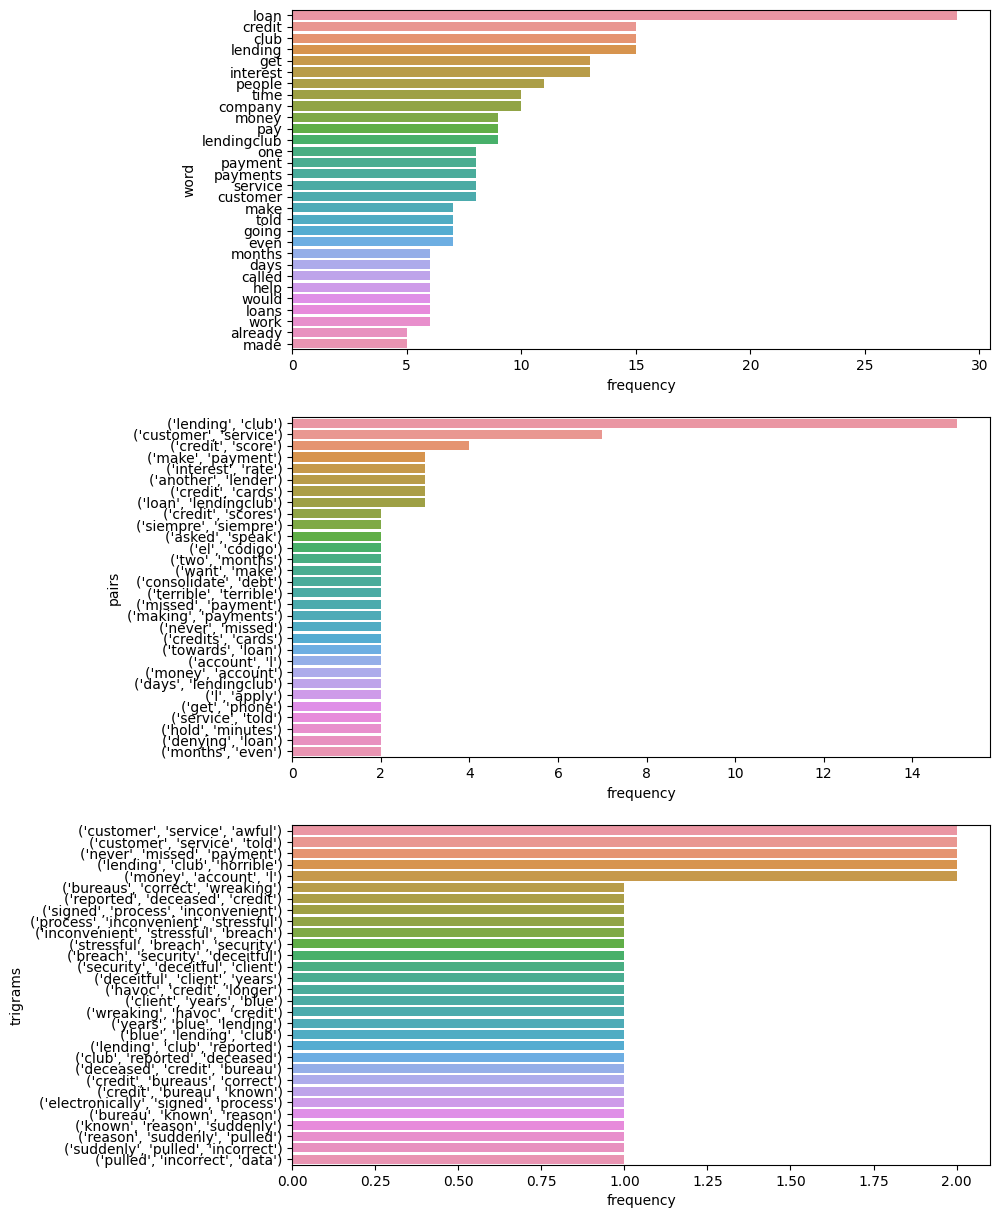

In [12]:
# Single Company (2)
filename = 'review.csv'

Rate = 1
Date = '2020'

word_freq, word_pairs, trigrams = trends_analyze(filename, Rate, Date)
plot_chart(word_freq, word_pairs, trigrams)

In [120]:
# Multi Company (1)
WEBSITE = ['www.888.com', 'www.ladbrokes.com', 'www.skybet.com', 'www.paddypower.com', 'williamhill.com']
Page = [30, 113, 73, 106, 197]

df_bag = pd.DataFrame()

for i in range(len(WEBSITE)):
    
    df = comment_scrape(WEBSITE[i], Page[i])
    df_bag = pd.concat([df_bag, df])
    
df_bag.to_csv('review.csv')

Rate counts shows below:
1    357
5    137
4     65
3     15
2      6
Name: Rate, dtype: int64

Rate counts ratio shows below:
1    0.615517
5    0.236207
4    0.112069
3    0.025862
2    0.010345
Name: Rate, dtype: float64

Review groupby year shows below:
Date
2013      8
2014     63
2015     43
2016     53
2017     34
2018     14
2019     37
2020     89
2021    131
2022    102
2023      6
Name: Review, dtype: int64

Scraped 580 reviews of www.888.com
Rate counts shows below:
1    1575
5     486
4      69
2      67
3      43
Name: Rate, dtype: int64

Rate counts ratio shows below:
1    0.703125
5    0.216964
4    0.030804
2    0.029911
3    0.019196
Name: Rate, dtype: float64

Review groupby year shows below:
Date
2012      4
2013      5
2014    119
2015    358
2016    119
2017    139
2018    159
2019    168
2020    293
2021    352
2022    470
2023     54
Name: Review, dtype: int64

Scraped 2240 reviews of www.ladbrokes.com
Rate counts shows below:
1    1167
5     131
2      58
4    

HTTPError: HTTP Error 403: Forbidden

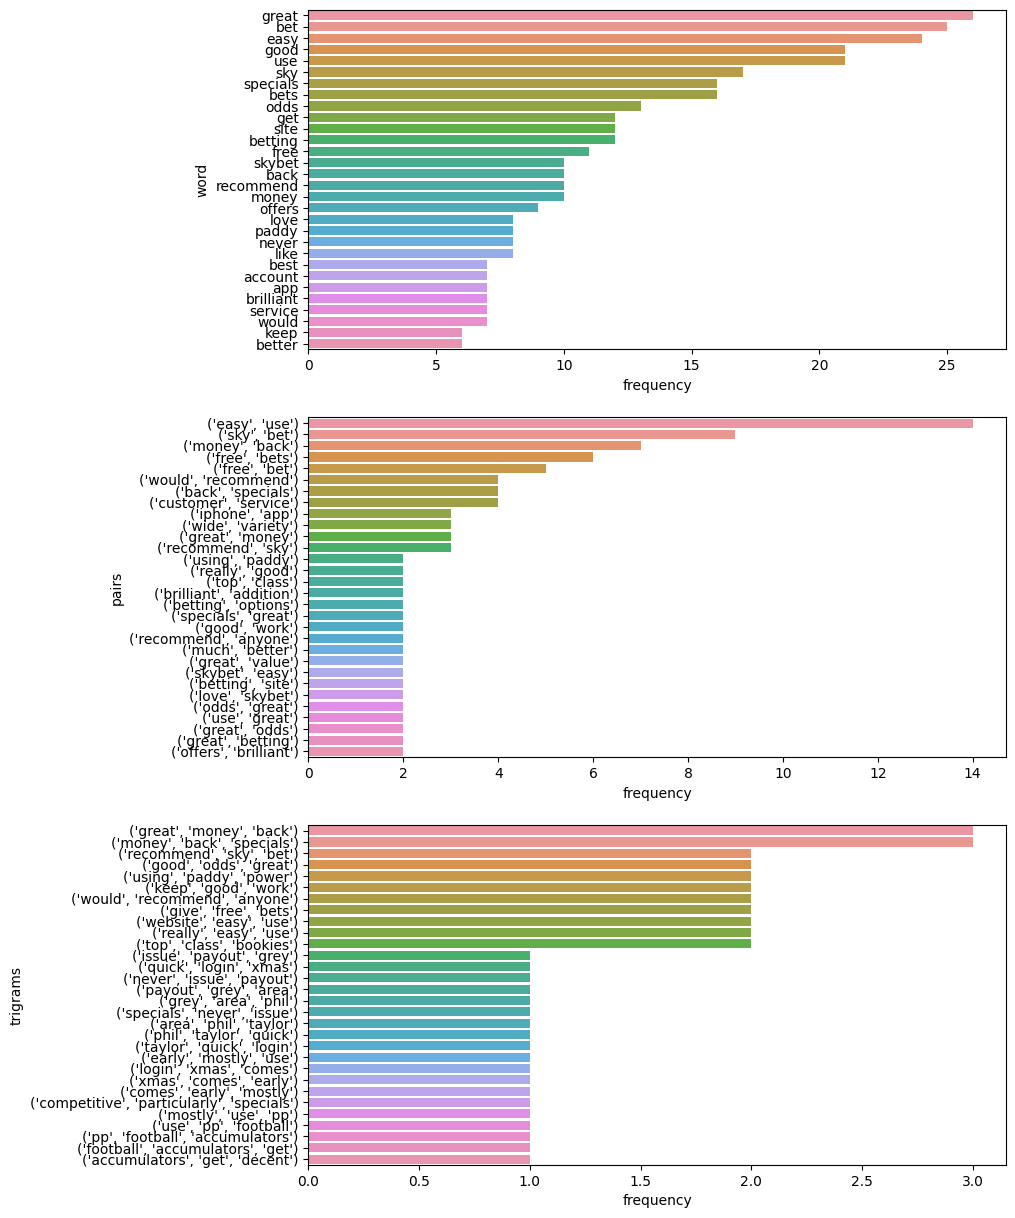

In [8]:
# Multi Company (2)
filename = 'review.csv'

Rate = 5
Date = '2012'

word_freq, word_pairs, trigrams = trends_analyze(filename, Rate, Date)
plot_chart(word_freq, word_pairs, trigrams)
# plot_chart(word_freq_bag, word_pairs_bag, trigrams_bag)

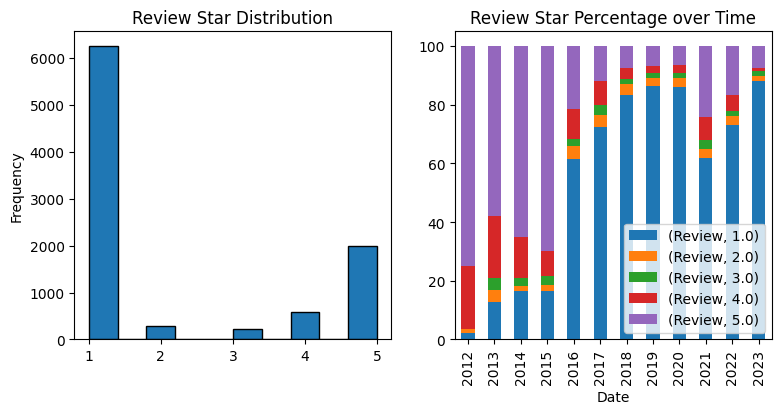

In [317]:
# review star split percentage

review_star_split(df_bag)

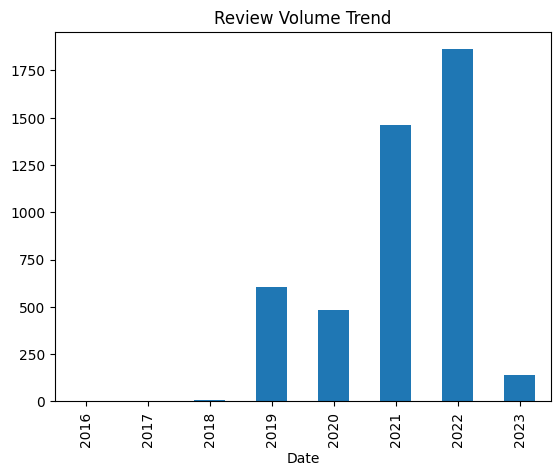

In [13]:
# review volume trend

review_volume_trend(df)

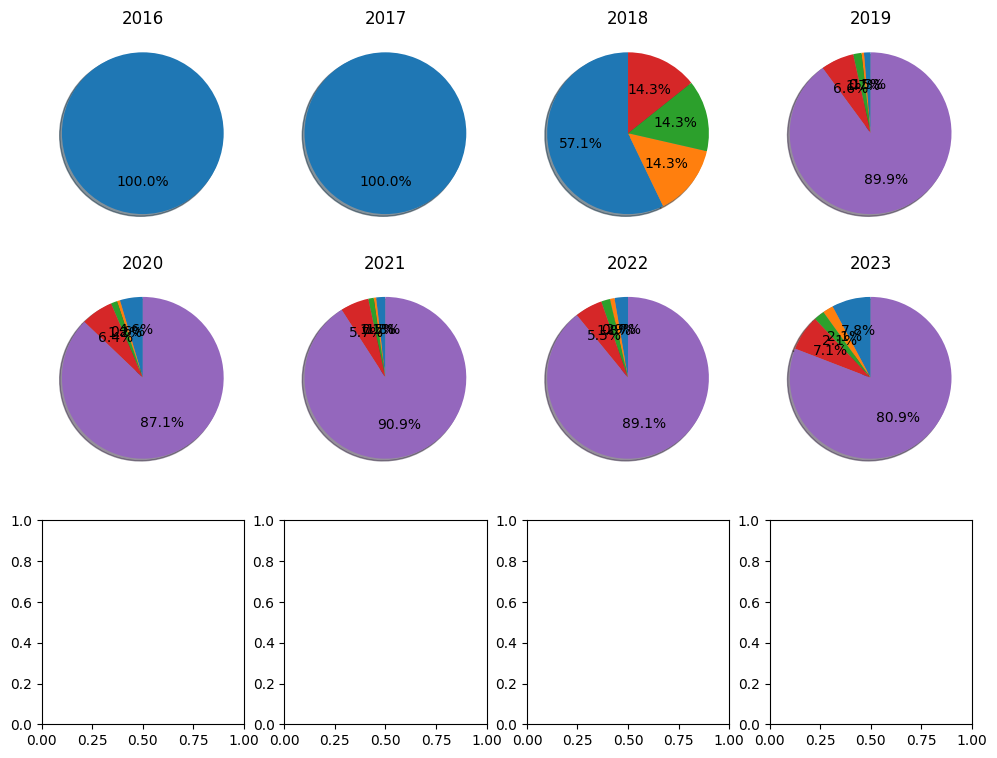

In [14]:
# pie chart of reviews

review_pie_chart(df)

In [23]:
def comment_scrape_new(WEBSITE, Page):
    comments = []
    rates = []
    dates = []

    # type in the website you want to scrape and analyze the trends over time!!!!!
    # example WEBSITE = 'www.betfair.com'
    
    user_agents_list = [
            'Mozilla/5.0 (iPad; CPU OS 13_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_16_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36',
            'python-requests/3.10.0',
            'python-requests/2.14.0',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36',
            'Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1',
            'Mozilla/4.0 (compatible; MSIE 9.0; Windows NT 6.1)',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36 Edg/87.0.664.75',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18363'
        ]
    

    for page in range(1, Page):
        time.sleep(random.randint(0, 2))
        if page == 1:
            req = Request(
                    url='https://www.trustpilot.com/review/'+ WEBSITE + '?languages=all&sort=recency',
                    headers={'User-Agent': random.choice(user_agents_list)}
                )
#             url = ur.urlopen('https://www.trustpilot.com/review/'+ WEBSITE)

        else:
            req = Request(
                    url='https://www.trustpilot.com/review/'+ WEBSITE +'?languages=all&page={}&sort=recency'.format(str(page)),
                    headers={'User-Agent': random.choice(user_agents_list)}
                )
            
#             url = ur.urlopen('https://www.trustpilot.com/review/'+ WEBSITE +'?page=' + str(page))
            
        content = urlopen(req).read()
        soup = BeautifulSoup(content, 'lxml')

        table_com_date = soup.findAll('div',attrs={"class":"styles_reviewContent__0Q2Tg"})
        table_rate = soup.findAll('div',attrs={"class":"styles_reviewHeader__iU9Px"})

        # scrape rates
        for x in table_rate:
            rates.append(x['data-service-review-rating'])

        # scrape comments and dates
        for x in table_com_date:

            comments.append(x.find('p').text)
            date = x.find('p', attrs = {"class": "typography_body-m__xgxZ_ typography_appearance-default__AAY17 typography_color-black__5LYEn"}).text[20:]
            date = datetime.strptime(date , "%B %d, %Y")
            dates.append(date)
        
    d = {'Review': comments, 'Rate': rates,'Date': dates }
    df = pd.DataFrame(d)
    df = df.set_index(['Date'])
    df['Company'] = WEBSITE
    
    # print ratio
    print('Rate counts shows below:')
    print(df['Rate'].value_counts())
    print('\nRate counts ratio shows below:')
    print(df.Rate.value_counts(normalize=True))
    
    print('\nReview groupby year shows below:')
    print(df.groupby(df.index.year)['Review'].count())
    
    print('\nScraped ' + str(len(df)) + ' reviews of ' + WEBSITE)
    
    return df

In [ ]:
# Single Company (1)

WEBSITE = 'lendingclub.com'
Page = 229
df = comment_scrape_new(WEBSITE, Page)
df.to_csv('review.csv')

In [16]:
def trends_analyze_new(filename, Rate, Date, Company):
    
    # read
    df = pd.read_csv (filename, lineterminator='\n')
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company]

    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] = [datetime.strptime(df['Date'].iloc[i], "%Y-%m-%d") for i in range(len(df['Review']))]
    df = df.set_index(['Date'])
    df = df.loc[df['Rate'] == Rate].loc[Date]
    
    sentence = " ".join(df['Review'])
    # creates tokens, creates lower class, removes numbers and lemmatizes the words
    new_tokens = word_tokenize(sentence)
    new_tokens = [t.lower() for t in new_tokens]
    new_tokens =[t for t in new_tokens if t not in stopwords.words('english')]
    new_tokens = [t for t in new_tokens if t.isalpha()]

    # #counts the words, pairs and trigrams
    counted = Counter(new_tokens)
    counted_2= Counter(ngrams(new_tokens,2))
    counted_3= Counter(ngrams(new_tokens,3))

    # #creates 3 data frames and returns thems
    word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)
    word_pairs =pd.DataFrame(counted_2.items(),columns=['pairs','frequency']).sort_values(by='frequency',ascending=False)
    trigrams =pd.DataFrame(counted_3.items(),columns=['trigrams','frequency']).sort_values(by='frequency',ascending=False)

    return word_freq, word_pairs, trigrams
    

In [17]:
def plot_chart_new(word_freq, word_pairs, trigrams):
    # create subplot of the different data frames
    fig, axes = plt.subplots(3,1,figsize=(9,15))
    sns.barplot(ax=axes[0],x='frequency',y='word',data=word_freq.head(30))
    sns.barplot(ax=axes[1],x='frequency',y='pairs',data=word_pairs.head(30))
    sns.barplot(ax=axes[2],x='frequency',y='trigrams',data=trigrams.head(30))
    
    return 

In [18]:
def review_star_split_new(filename, Company):
    # read
    df = pd.read_csv (filename, lineterminator='\n')

    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] = [datetime.strptime(df['Date'].iloc[i], "%Y-%m-%d") for i in range(len(df['Review']))]
    df = df.set_index(['Date'])
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
    fig, axd = plt.subplot_mosaic([['ax0', 'ax0'], ['ax1', 'ax2']],figsize=(9, 11))
    
    df.groupby([df.index.year, "Rate"]).count().unstack().plot(kind='bar', edgecolor='black',ax = axd['ax0'])
    axd['ax0'].set_title("Review Star Distribution Over Time of "+ Company)
    axd['ax0'].legend(title="")
    
    df['Rate'].plot(kind='hist', edgecolor='black',ax=axd['ax1'])
    axd['ax1'].set_title("Review Star Distribution")
    
    df = df.groupby([df.index.year, "Rate"]).count()
    df = df.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))
    df.unstack().plot(kind='bar', stacked=True, ax=axd['ax2'])
    
    axd['ax2'].set_title("Review Star Percentage over Time")
    axd['ax2'].legend(title="")
    plt.show()
    return

In [19]:
def review_volume_trend_new(filename, Company):
    df = pd.read_csv (filename, lineterminator='\n')

    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] = [datetime.strptime(df['Date'].iloc[i], "%Y-%m-%d") for i in range(len(df['Review']))]
    df = df.set_index(['Date'])
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
#     plt.figure(figsize=(width, height))
    fig = plt.figure(figsize=(9, 4))
    df = df.groupby(df.index.year).count().pop('Review')
    df.plot(kind='bar', stacked=True)
    plt.ylabel('Number of Reviews')
    plt.title("Review Volume Trend")
    plt.show()

    return

In [20]:
def review_pie_chart_new(filename, Company):
    df = pd.read_csv (filename, lineterminator='\n')

    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] = [datetime.strptime(df['Date'].iloc[i], "%Y-%m-%d") for i in range(len(df['Review']))]
    df = df.set_index(['Date'])
    
    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
    
    
    
    number_group = df.groupby(df.index.year).ngroups
    
    df = df.groupby([df.index.year, "Rate"]).count()
    df = df.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))

    nrow = len(df.index.levels[0])//4 + 1

    fig, axes = plt.subplots(nrows=nrow, ncols=4,figsize=(11, 2*nrow))
    for i, e in enumerate(df.index.levels[0]):
        yy = df.loc[e]["Review"].tolist()

        axes[i//4 , i%4].pie(yy,  autopct='%1.1f%%', shadow=True, startangle=90)
        axes[i//4 , i%4].set_title(e)
    
    plt.show()
    
    return

In [92]:
def review_chart_plot_new(filename, Company):
    # read
    df = pd.read_csv (filename, lineterminator='\n')
#     df['Review'] = df['Review'].astype(str)
    
    # joins all the sentenses
    df['Review'] = [df['Review'].iloc[i].replace("\r", " ") for i in range(len(df['Review']))]
    df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df = df.set_index(['Date'])

    if Company == 'All':
        df = df
    else:
        df = df.loc[df['Company'] == Company].drop(['Company'], axis=1)
    
    df['Rate'] = df['Rate'].astype(float)
    
    
    # review_star_split
    
    fig0, axd = plt.subplot_mosaic([['ax0', 'ax0'], ['ax1', 'ax2'], ['ax3','ax3']],figsize=(15, 15))
#     fig0, ((ax0, ax0), (ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2)
    
    
    df.groupby([df.index.year, "Rate"]).count().unstack().plot(kind='bar', edgecolor='black',ax = axd['ax0'])
    axd['ax0'].set_title("Review Star Distribution Over Time of "+ Company)
    axd['ax0'].legend(title="")
    
    df['Rate'].plot(kind='hist', edgecolor='black',ax=axd['ax1'])
    axd['ax1'].set_title("Review Star Distribution")
    
    df_rs = df.groupby([df.index.year, "Rate"]).count()
    df_rs = df_rs.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))
    df_rs.unstack().plot(kind='bar', stacked=True, ax=axd['ax2'])
    
    axd['ax2'].set_title("Review Star Percentage over Time")
    axd['ax2'].legend(title="")
    
    # review_volume_trend

    df_rv = df.groupby(df.index.year).count().pop('Review')
    df_rv.plot(kind='bar', stacked=True, ax=axd['ax3'])
    axd['ax3'].set_ylabel('Number of Reviews')
    axd['ax3'].set_title("Review Volume Trend")
    
    # review_pie_chart
    
    number_group = df.groupby(df.index.year).ngroups
    
    df_rp = df.groupby([df.index.year, "Rate"]).count()
    df_rp = df_rp.groupby(level=0, group_keys=False).apply(lambda x:100 * x / float(x.sum()))

    nrow = len(df_rp.index.levels[0])//4 + 1

    fig2 = plt.figure(figsize=(15, 4*nrow))
    
    for i, e in enumerate(df_rp.index.levels[0]):
#         ax = fig0.subplot_mosaic([['ax4','ax4']])
        ax = fig2.add_subplot(nrow, 4, i+1)
        yy = df_rp.loc[e]["Review"].tolist()
        labels = list(df_rp.loc[e]["Review"].index.values)
        ax.pie(yy,  autopct='%1.1f%%', shadow=True, startangle=90)
        labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, yy)]
        plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)
        ax.set_title(e)  
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    return

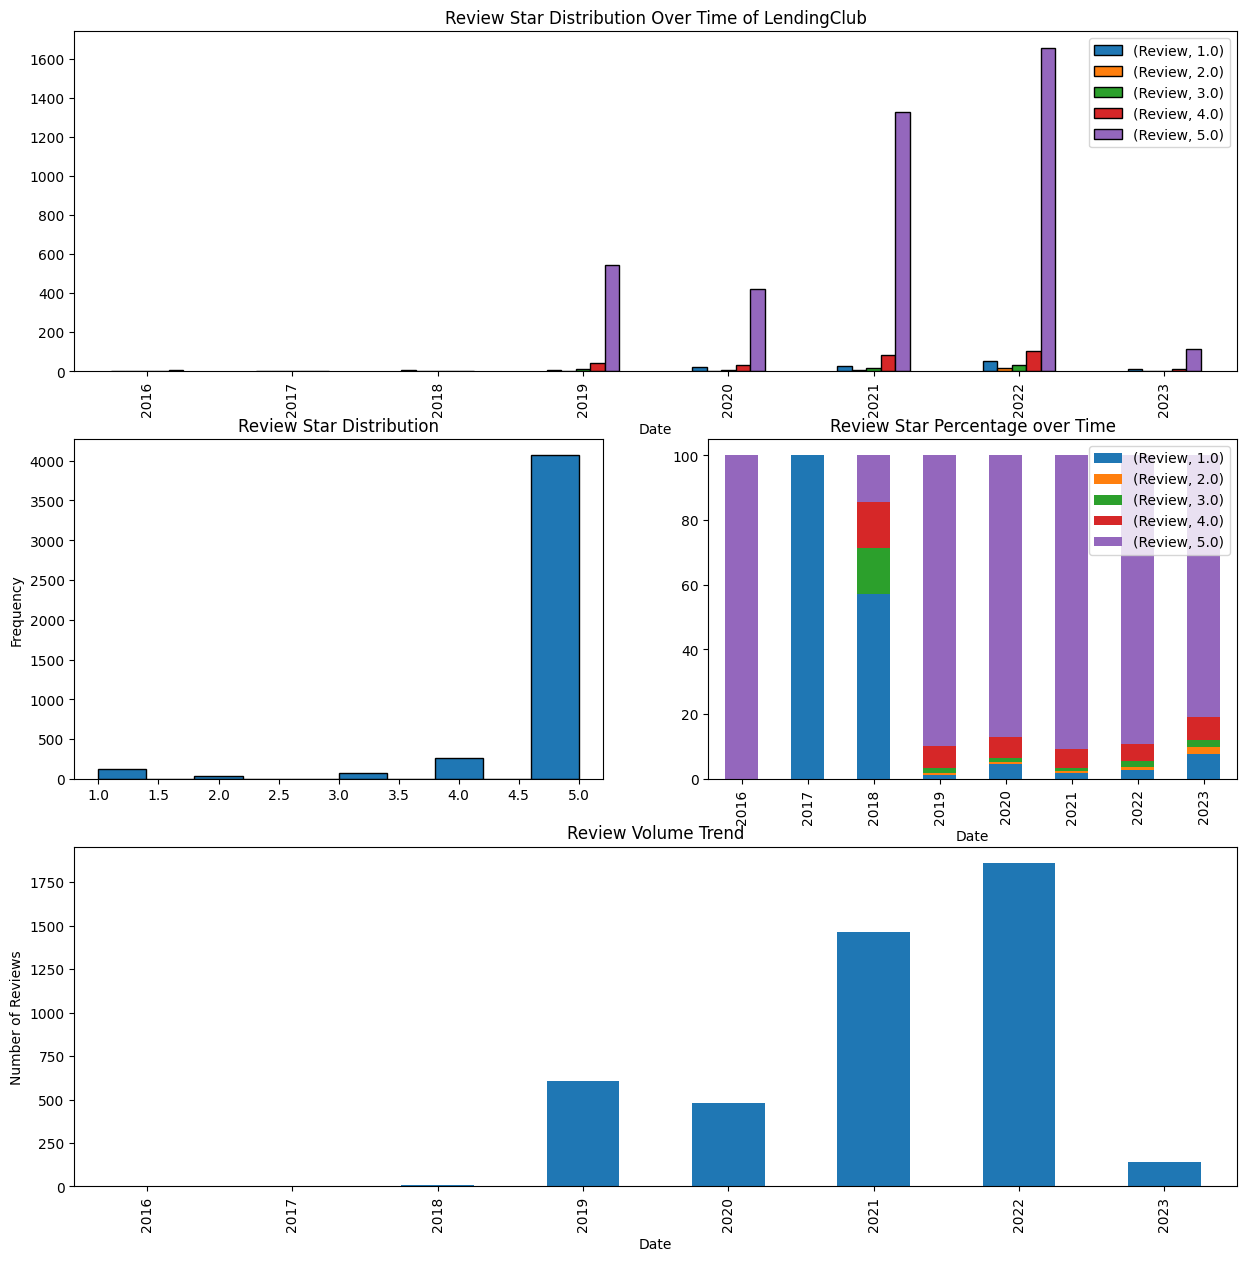

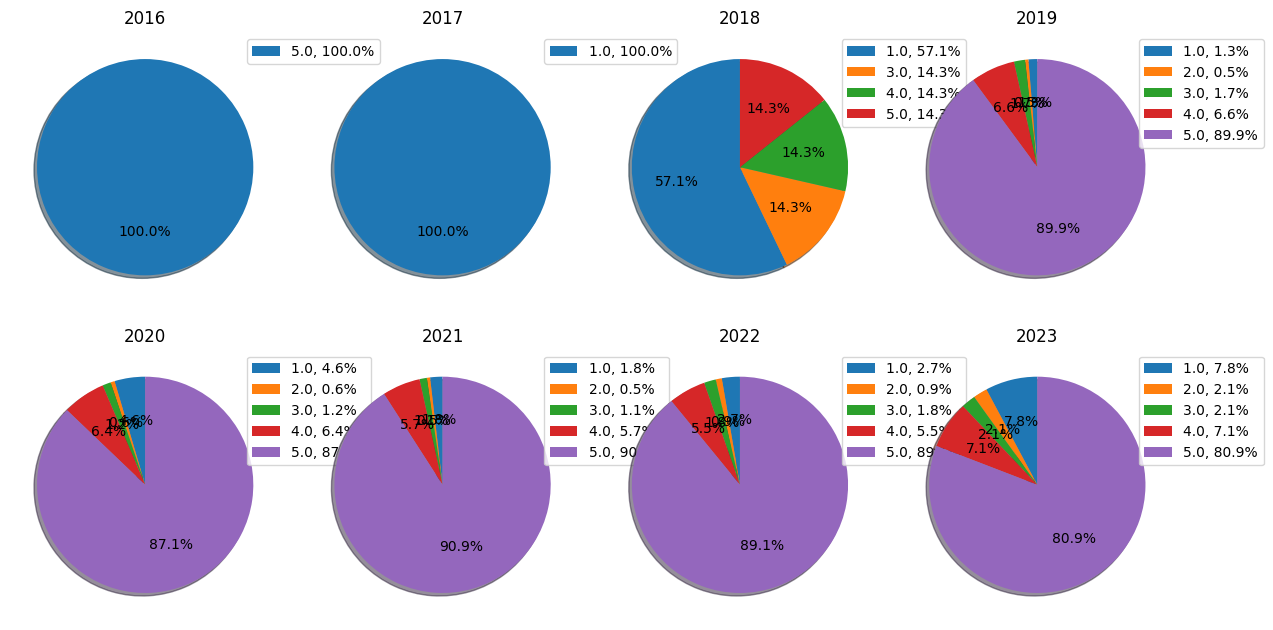

In [93]:
filename = 'review_trustpilot_LendingClub.csv'
Company = 'LendingClub'
review_chart_plot_new(filename, Company)

Start working on www.betfair.com


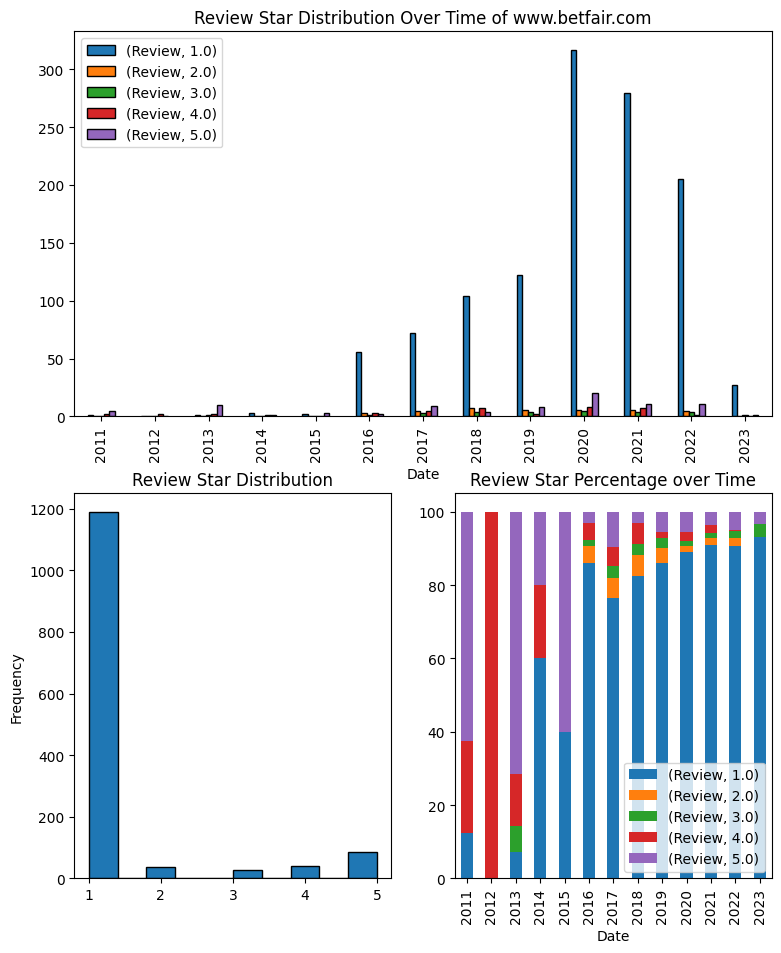

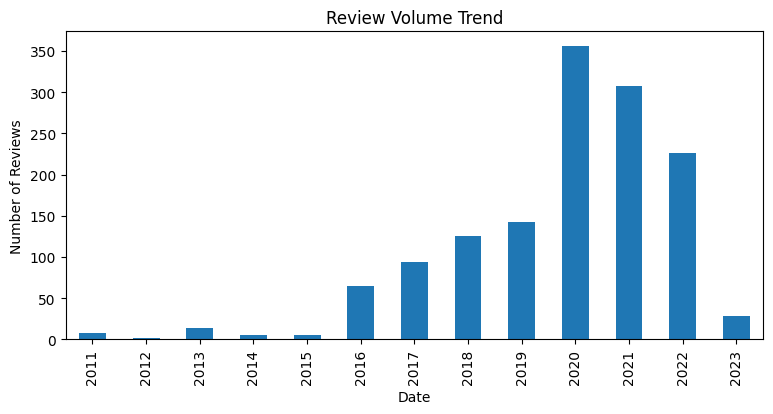

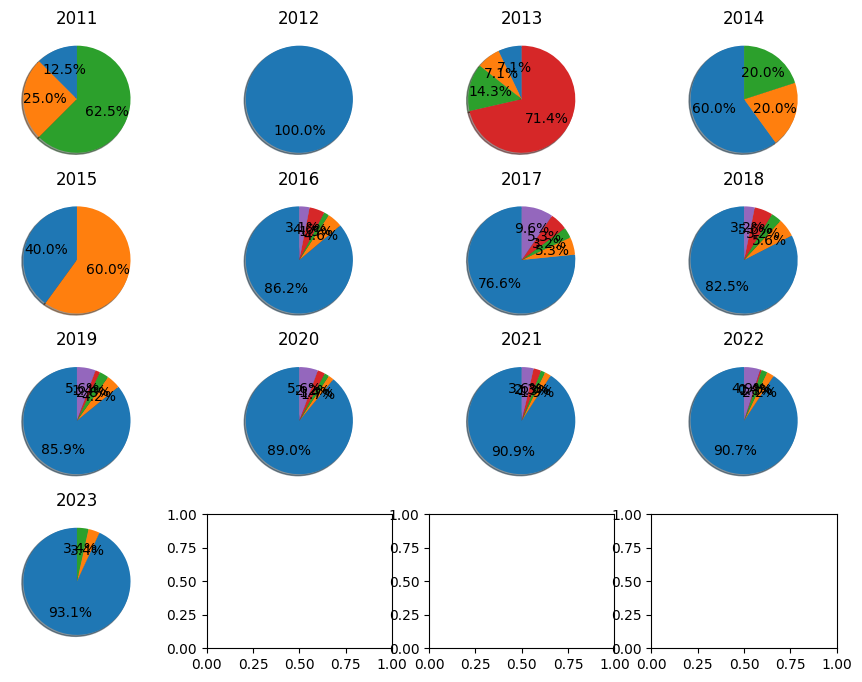

Start analyzing word frequency of www.betfair.com
Start working on www.888.com


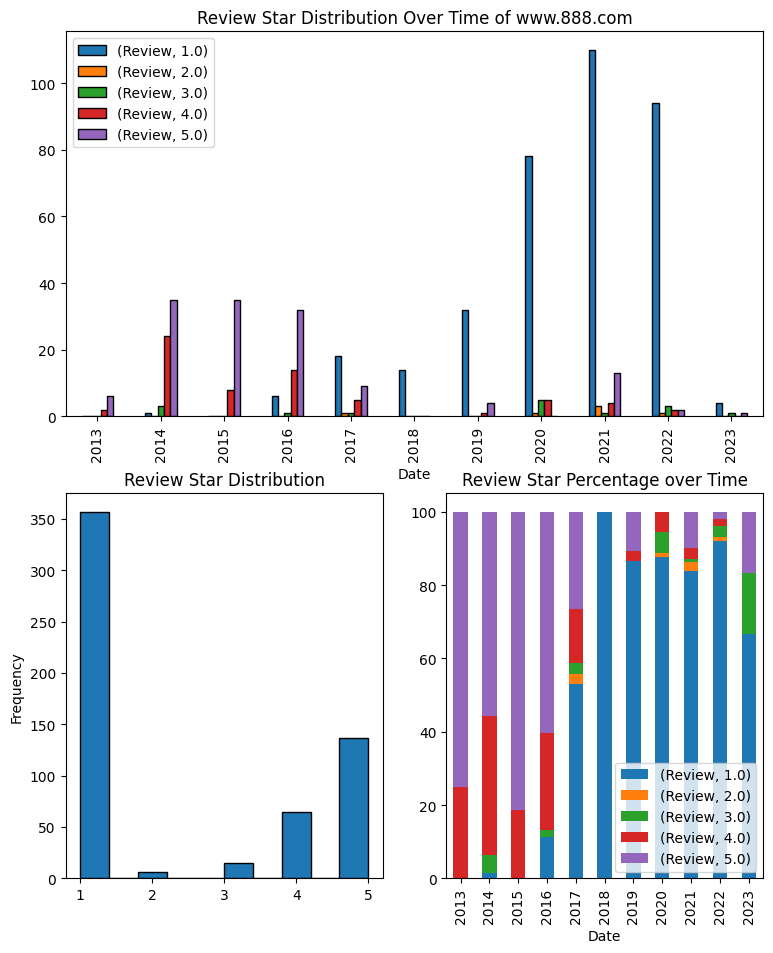

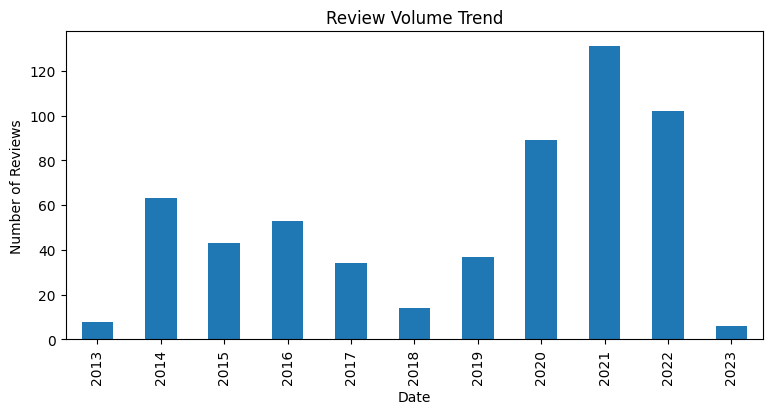

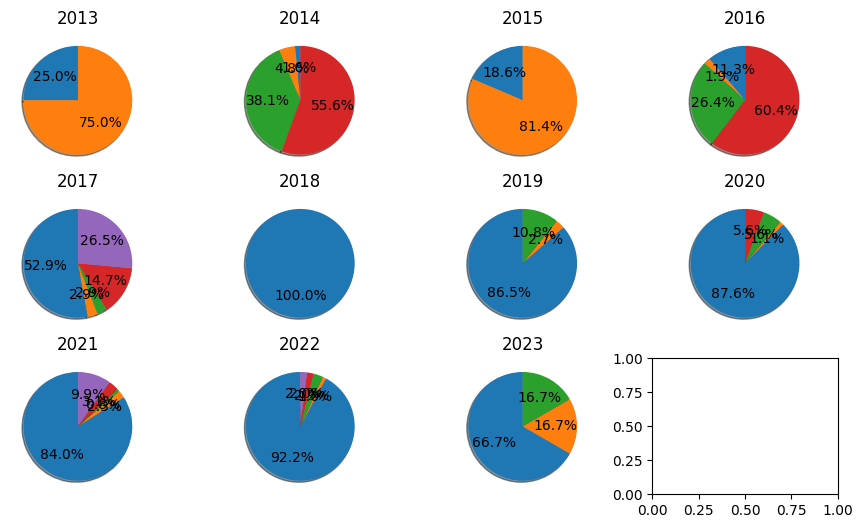

Start analyzing word frequency of www.888.com
Start working on www.ladbrokes.com


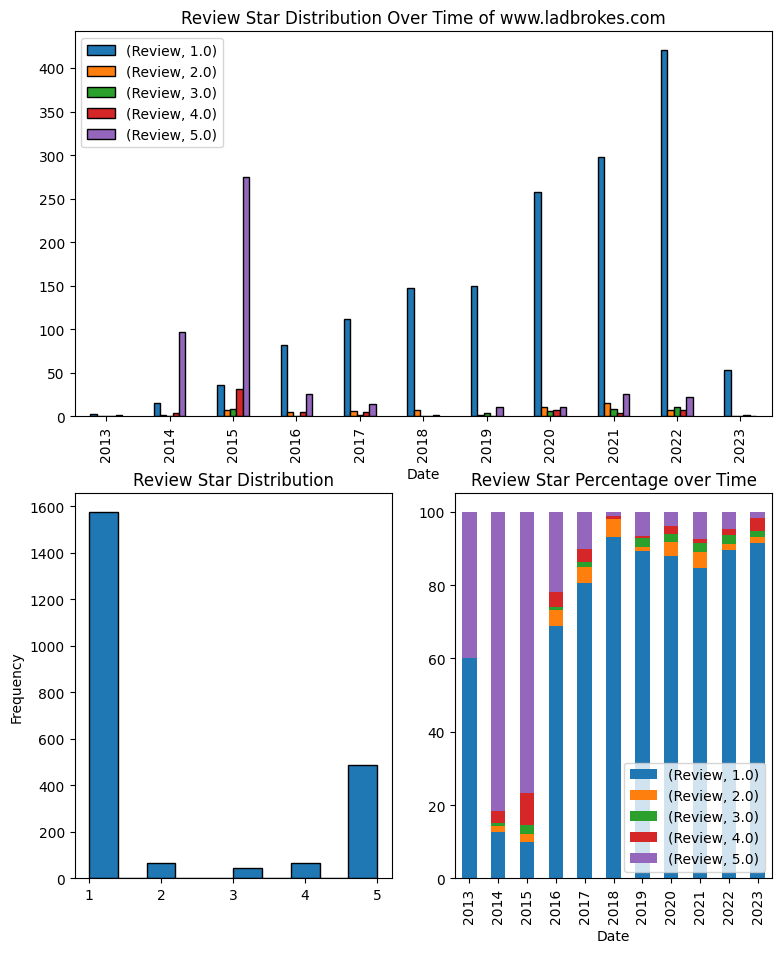

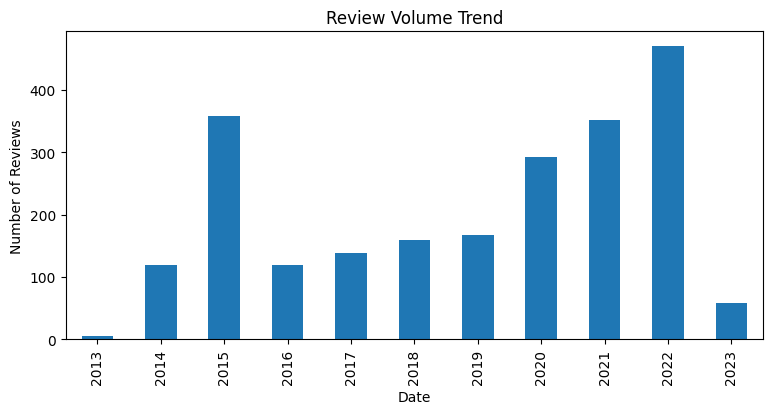

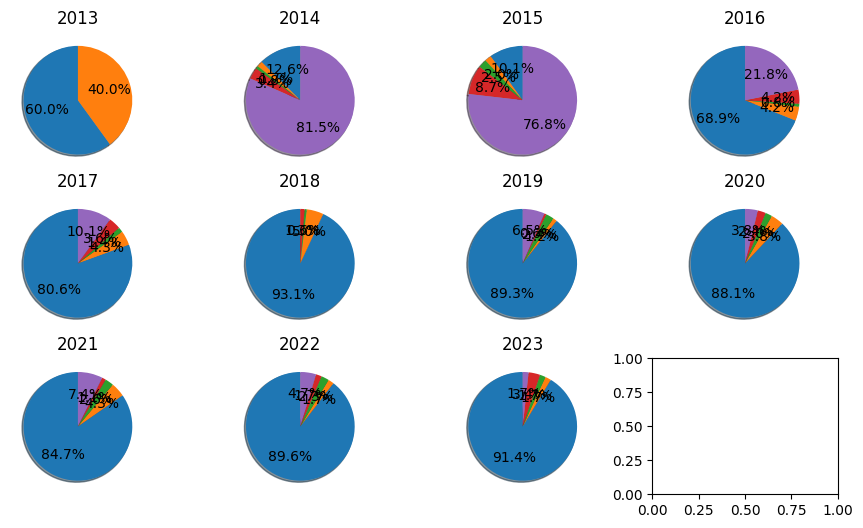

Start analyzing word frequency of www.ladbrokes.com
Start working on www.skybet.com


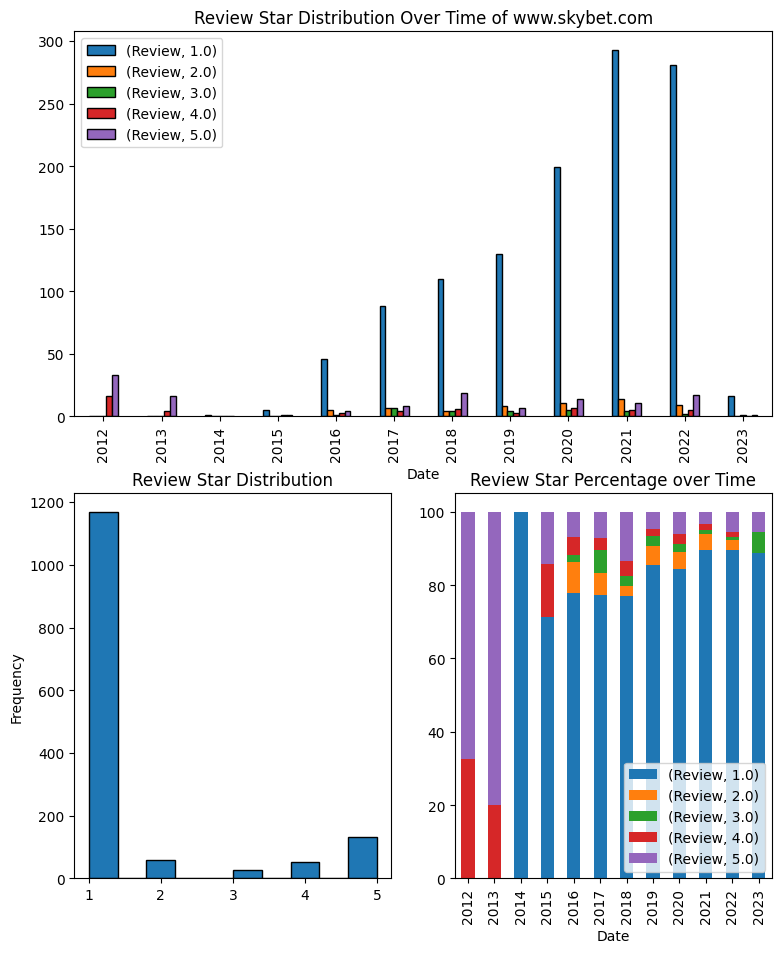

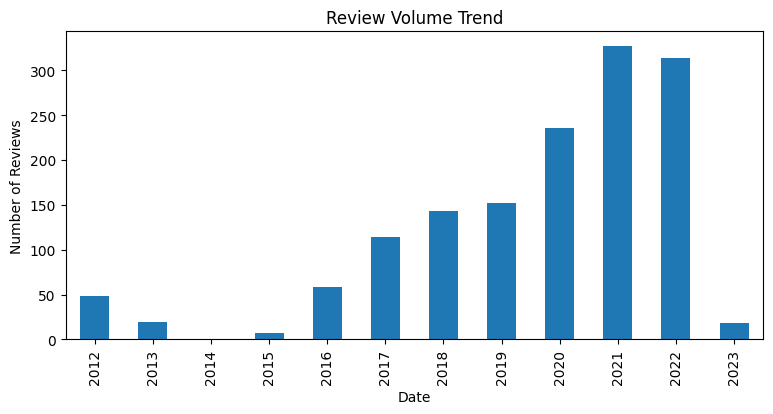

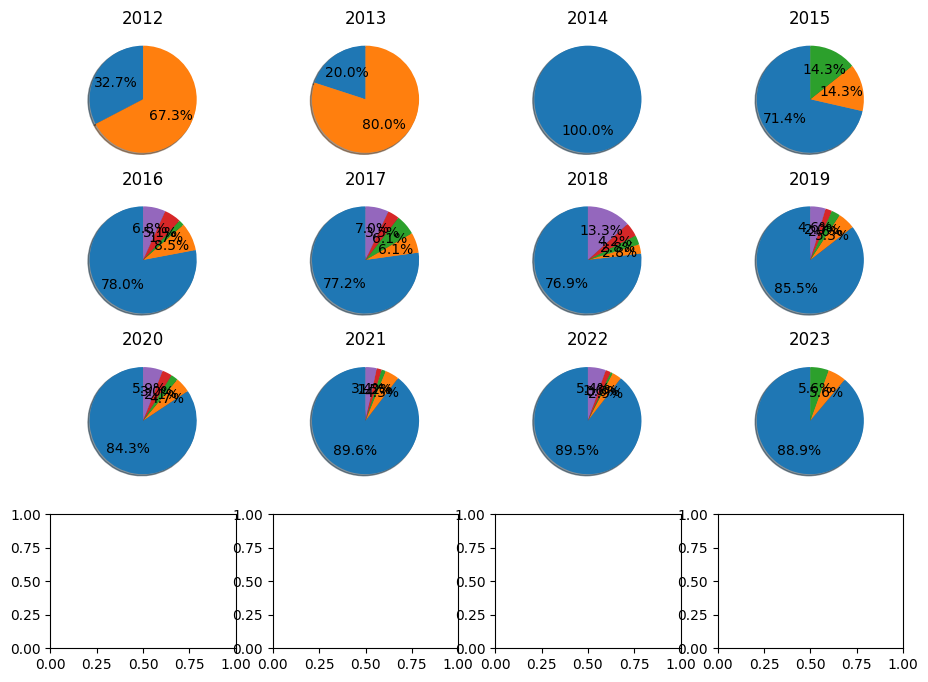

Start analyzing word frequency of www.skybet.com
Start working on www.paddypower.com


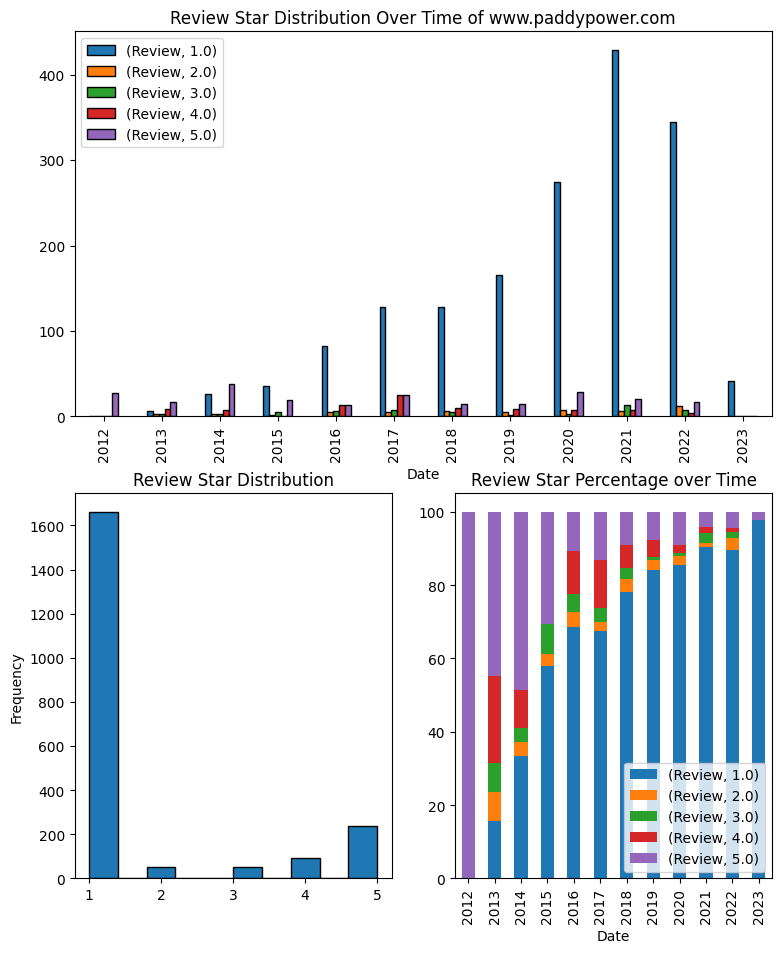

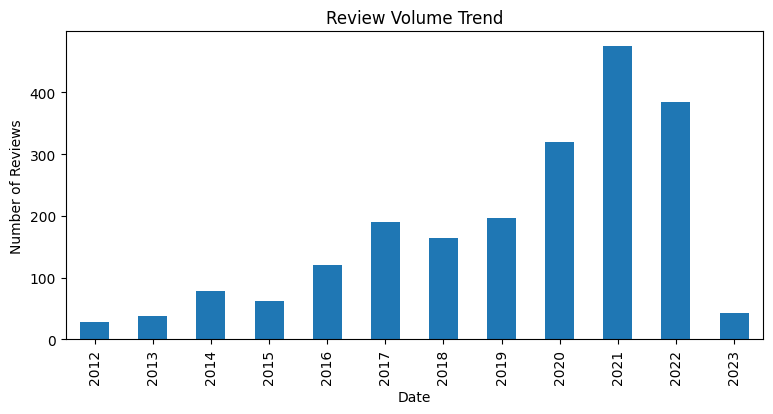

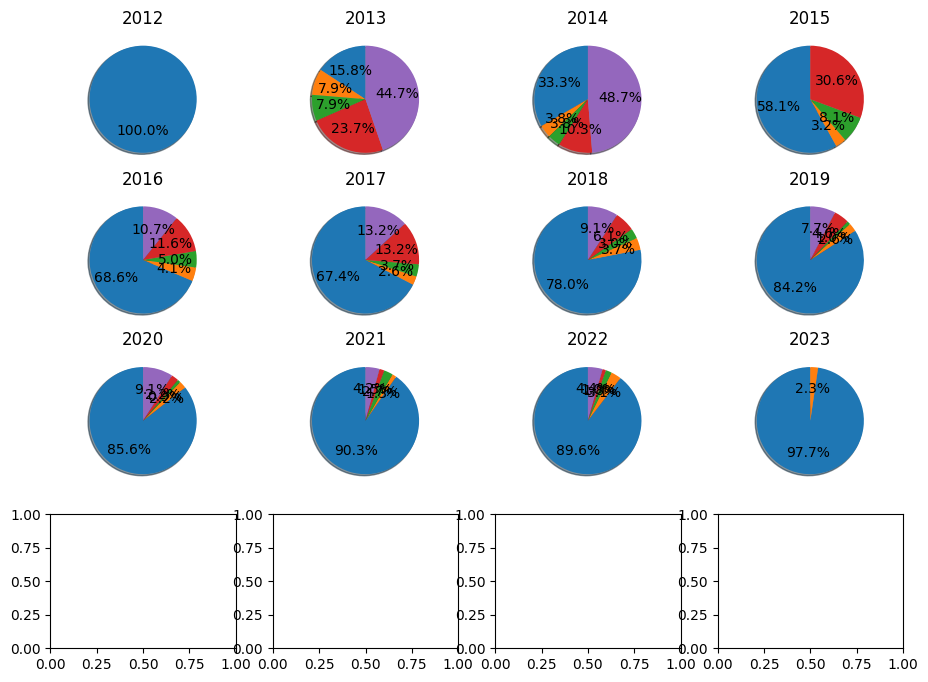

Start analyzing word frequency of www.paddypower.com
Start working on williamhill.com


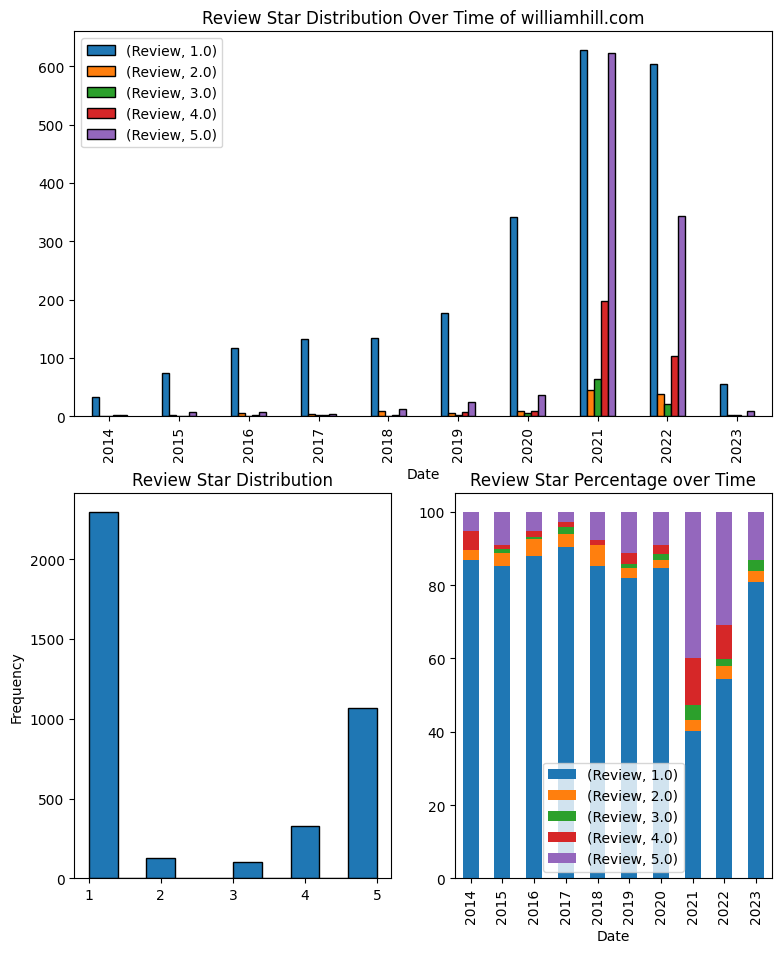

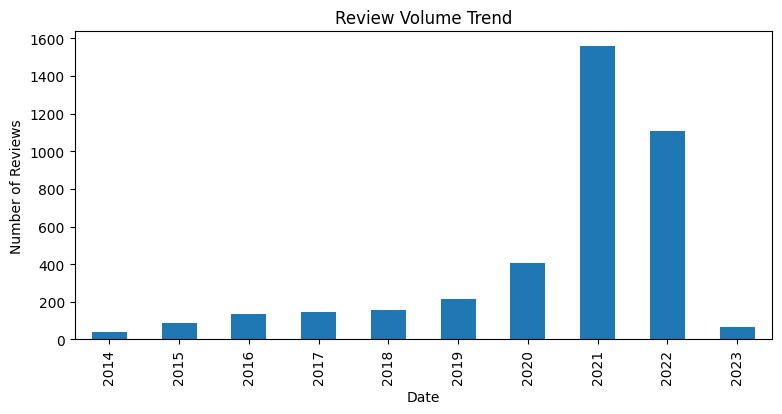

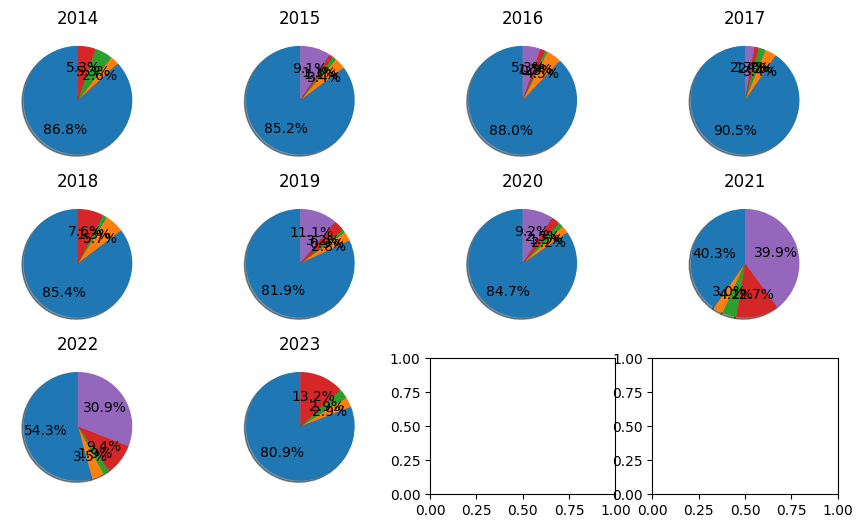

Start analyzing word frequency of williamhill.com


In [16]:
# Seeing each brand individually to see how player perception is changing for each brand vs. in aggregate

WEBSITE = ['www.betfair.com', 'www.888.com', 'www.ladbrokes.com', 'www.skybet.com', 'www.paddypower.com', 'williamhill.com']
Page = [70, 30, 113, 73, 106, 197]

df_bag = pd.DataFrame()

for i in range(len(WEBSITE)):
    
    df = comment_scrape_new(WEBSITE[i], Page[i])
    df_bag = pd.concat([df_bag, df])
    
df_bag.to_csv('review_new.csv')

filename = 'review_new.csv'

Rate = [1,2,3,4,5]
Date = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']
WEBSITE = ['www.betfair.com', 'www.888.com', 'www.ladbrokes.com', 
           'www.skybet.com', 'www.paddypower.com', 'williamhill.com']

word_bag = pd.DataFrame()
for i, Company in enumerate(WEBSITE):
    print('Start working on '+ Company)
    review_star_split_new(filename, Company)
    review_volume_trend_new(filename, Company)
    review_pie_chart_new(filename, Company)
    print('Start analyzing word frequency of ' + Company)
    
    for ii, d in enumerate(Date):
        print('\rFinished {}%'.format(round((ii+1)*100 / len(Date)), 2), end="\r" )
        for r in Rate:
            word_freq, word_pairs, trigrams = trends_analyze_new(filename, r, d, Company)
            if not word_freq.empty:
                word_dict = dict(zip(word_freq.word.head(30), word_freq.frequency.head(30)))
                pair_dict = dict(zip(word_pairs.pairs.head(30), word_pairs.frequency.head(30)))
                tri_dict = dict(zip(trigrams.trigrams.head(30), trigrams.frequency.head(30)))
                word_bag_sub = pd.DataFrame({'Company': Company, 'Year' : d, 'Rate' : r, 'Word' : [word_dict],'Pair' : [pair_dict],'Tri' : [tri_dict]})
                word_bag = pd.concat([word_bag, word_bag_sub])
        
word_bag.to_csv('review_word_freq.csv')


In [17]:
# Seeing what players are more concerned about or pleased with for each brand. 


# Over Years

WEBSITE = ['www.betfair.com', 'www.888.com', 'www.ladbrokes.com', 
           'www.skybet.com', 'www.paddypower.com', 'williamhill.com']
Date = ['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','2023']

# Concerned about (Rate == 1, 2, and 3)
Rate_concerned = [1, 2, 3]


for company in WEBSITE:
    try:
       os.makedirs('review_keywords/' + company)
    except FileExistsError:
       # directory already exists
       pass
    for year in Date:
        word_bag_pesudo_null = pd.DataFrame()
        for i in Rate_concerned:
            word_bag_pesudo = word_bag.loc[(word_bag['Company'] == company) 
                                           & (word_bag['Year'] == year) & (word_bag['Rate'] == i)]
            
            word_bag_pesudo_null = pd.concat([word_bag_pesudo_null, word_bag_pesudo])
        
        dict_column_word = word_bag_pesudo_null['Word'].tolist()
        result_word = {}
        for d in dict_column_word:
            for key, value in d.items():
                if key in result_word:
                    result_word[key] += value
                else:
                    result_word[key] = value
        result_word = {k: v for k, v in sorted(result_word.items(), key=lambda item: item[1], reverse=True)}  
        
        dict_column_pair = word_bag_pesudo_null['Pair'].tolist()
        result_pair = {}
        for d in dict_column_pair:
            for key, value in d.items():
                if key in result_pair:
                    result_pair[key] += value
                else:
                    result_pair[key] = value
        
        result_pair = {k: v for k, v in sorted(result_pair.items(), key=lambda item: item[1], reverse=True)} 
        
        dict_column_tri = word_bag_pesudo_null['Tri'].tolist()
        result_tri = {}
        for d in dict_column_tri:
            for key, value in d.items():
                if key in result_tri:
                    result_tri[key] += value
                else:
                    result_tri[key] = value
        result_tri = {k: v for k, v in sorted(result_tri.items(), key=lambda item: item[1], reverse=True)} 
        
        # comment out if graphs are not needed
#         if bool(result_word):
            
#             word_freq = pd.DataFrame({'word': result_word.keys(), 'frequency': result_word.values()})
#             word_pairs = pd.DataFrame({'pairs': result_pair.keys(), 'frequency': result_pair.values()})
#             trigrams = pd.DataFrame({'trigrams': result_tri.keys(), 'frequency': result_tri.values()})
#             print('Concerned: Charts of ' + company + ' in ' + year)
#             plot_chart(word_freq, word_pairs, trigrams)
            
        word_bag_pesudo_new = pd.DataFrame({'Company': company, 'Year': year, 'Word': [result_word], 'Pair': [result_pair], 'Tri': [result_tri]})
        word_bag_pesudo_new.to_csv('review_keywords/' + company +'/' +company + '_'+ year + '_concerned_keywords' + '.csv')

# Pleased with (Rate == 5 and 4)
Rate_pleased = [4, 5]

for company in WEBSITE:
    try:
       os.makedirs('review_keywords/' + company)
    except FileExistsError:
       # directory already exists
       pass
    for year in Date:
        word_bag_pesudo_null = pd.DataFrame()
        for i in Rate_pleased:
            word_bag_pesudo = word_bag.loc[(word_bag['Company'] == company) 
                                           & (word_bag['Year'] == year) & (word_bag['Rate'] == i)]
        
            word_bag_pesudo_null = pd.concat([word_bag_pesudo_null, word_bag_pesudo])


        dict_column_word = word_bag_pesudo_null['Word'].tolist()
        result_word = {}
        for d in dict_column_word:
            for key, value in d.items():
                if key in result_word:
                    result_word[key] += value
                else:
                    result_word[key] = value
        result_word = {k: v for k, v in sorted(result_word.items(), key=lambda item: item[1], reverse=True)}  
        
        dict_column_pair = word_bag_pesudo_null['Pair'].tolist()
        result_pair = {}
        for d in dict_column_pair:
            for key, value in d.items():
                if key in result_pair:
                    result_pair[key] += value
                else:
                    result_pair[key] = value
        
        result_pair = {k: v for k, v in sorted(result_pair.items(), key=lambda item: item[1], reverse=True)} 
        
        dict_column_tri = word_bag_pesudo_null['Tri'].tolist()
        result_tri = {}
        for d in dict_column_tri:
            for key, value in d.items():
                if key in result_tri:
                    result_tri[key] += value
                else:
                    result_tri[key] = value
        result_tri = {k: v for k, v in sorted(result_tri.items(), key=lambda item: item[1], reverse=True)} 
        # comment out if graphs are not needed
#         if bool(result_word):
            
#             word_freq = pd.DataFrame({'word': result_word.keys(), 'frequency': result_word.values()})
#             word_pairs = pd.DataFrame({'pairs': result_pair.keys(), 'frequency': result_pair.values()})
#             trigrams = pd.DataFrame({'trigrams': result_tri.keys(), 'frequency': result_tri.values()})
#             print('Pleased: Charts of ' + company+ ' in ' + year)
#             plot_chart(word_freq, word_pairs, trigrams)
        
        word_bag_pesudo_new = pd.DataFrame({'Company': company, 'Year': year, 'Word': [result_word], 'Pair': [result_pair], 'Tri': [result_tri]})
        word_bag_pesudo_new.to_csv('review_keywords/' + company +'/' +company + '_'+ year + '_pleased_keywords' + '.csv')



In [18]:
# In Total for Each Brand

# Concerned

for company in WEBSITE:
    try:
       os.makedirs('review_keywords/' + company)
    except FileExistsError:
       # directory already exists
       pass
    
    word_bag_pesudo_null = pd.DataFrame()
    for i in Rate_concerned:
        word_bag_pesudo = word_bag.loc[(word_bag['Company'] == company) 
                                       & (word_bag['Rate'] == i)]

        word_bag_pesudo_null = pd.concat([word_bag_pesudo_null, word_bag_pesudo])

    dict_column_word = word_bag_pesudo_null['Word'].tolist()
    result_word = {}
    for d in dict_column_word:
        for key, value in d.items():
            if key in result_word:
                result_word[key] += value
            else:
                result_word[key] = value
    result_word = {k: v for k, v in sorted(result_word.items(), key=lambda item: item[1], reverse=True)}  

    dict_column_pair = word_bag_pesudo_null['Pair'].tolist()
    result_pair = {}
    for d in dict_column_pair:
        for key, value in d.items():
            if key in result_pair:
                result_pair[key] += value
            else:
                result_pair[key] = value

    result_pair = {k: v for k, v in sorted(result_pair.items(), key=lambda item: item[1], reverse=True)} 

    dict_column_tri = word_bag_pesudo_null['Tri'].tolist()
    result_tri = {}
    for d in dict_column_tri:
        for key, value in d.items():
            if key in result_tri:
                result_tri[key] += value
            else:
                result_tri[key] = value
    result_tri = {k: v for k, v in sorted(result_tri.items(), key=lambda item: item[1], reverse=True)} 


    word_bag_pesudo_new = pd.DataFrame({'Company': company, 'Word': [result_word], 'Pair': [result_pair], 'Tri': [result_tri]})
    word_bag_pesudo_new.to_csv('review_keywords/' + company +'/' +company + '_overall_concerned_keywords' + '.csv')
        
 # Pleased

for company in WEBSITE:
    try:
       os.makedirs('review_keywords/' + company)
    except FileExistsError:
       # directory already exists
       pass
    
    word_bag_pesudo_null = pd.DataFrame()
    for i in Rate_pleased:
        word_bag_pesudo = word_bag.loc[(word_bag['Company'] == company) 
                                       & (word_bag['Rate'] == i)]

        word_bag_pesudo_null = pd.concat([word_bag_pesudo_null, word_bag_pesudo])

    dict_column_word = word_bag_pesudo_null['Word'].tolist()
    result_word = {}
    for d in dict_column_word:
        for key, value in d.items():
            if key in result_word:
                result_word[key] += value
            else:
                result_word[key] = value
    result_word = {k: v for k, v in sorted(result_word.items(), key=lambda item: item[1], reverse=True)}  

    dict_column_pair = word_bag_pesudo_null['Pair'].tolist()
    result_pair = {}
    for d in dict_column_pair:
        for key, value in d.items():
            if key in result_pair:
                result_pair[key] += value
            else:
                result_pair[key] = value

    result_pair = {k: v for k, v in sorted(result_pair.items(), key=lambda item: item[1], reverse=True)} 

    dict_column_tri = word_bag_pesudo_null['Tri'].tolist()
    result_tri = {}
    for d in dict_column_tri:
        for key, value in d.items():
            if key in result_tri:
                result_tri[key] += value
            else:
                result_tri[key] = value
    result_tri = {k: v for k, v in sorted(result_tri.items(), key=lambda item: item[1], reverse=True)} 


    word_bag_pesudo_new = pd.DataFrame({'Company': company, 'Word': [result_word], 'Pair': [result_pair], 'Tri': [result_tri]})
    word_bag_pesudo_new.to_csv('review_keywords/' + company +'/' +company + '_overall_pleased_keywords' + '.csv')
       
        
        